In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm

In [3]:
from models.detector import Detector
from models.place_classifier import PlaceClassifier

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
from transformers import DistilBertModel, DistilBertConfig
from transformers import DistilBertTokenizer, DistilBertModel

In [5]:
from tensorflow.keras.applications import VGG16, EfficientNetB3
import tensorflow as tf

In [6]:
import matplotlib.pyplot as plt

In [7]:
classifier = PlaceClassifier()

In [8]:
detector = Detector()

INFO:absl:Using /tmp/tfhub_modules to cache modules.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
configuration = DistilBertConfig()

In [10]:
model_nlp = DistilBertModel(configuration)

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [12]:
ds_path = 'dataset'

In [13]:
def get_embedding(inputs):
    inputs = tokenizer(inputs, return_tensors="pt")
    outputs = model_nlp(**inputs)
    embeddings = outputs.last_hidden_state[:, -1].mean(axis = 0).detach().numpy()
    return embeddings

In [14]:
meta_fname = os.path.join(ds_path, '_meta.json')
with open(meta_fname, 'r') as f:
    meta_data = f.read()
meta_data = json.loads(meta_data)
meta_data = meta_data.get('data')

In [15]:
def get_objects_embedding(objects):
    obj_embeddings = []
    for obj in objects:
         obj_embeddings.append(get_embedding(obj))
    if len(obj_embeddings) == 0:
        return []
    else:
        mean_obj_emb = np.mean(obj_embeddings, axis = 0)
    return mean_obj_emb

In [16]:
def get_places_embedding(places_dict):
    places = places_dict.keys()
    places_emb = []
    for place in places:
        place = place.split('/')[0].replace('_', ' ')
        place_emb = get_embedding(place)
        places_emb.append(place_emb)
    if len(place_emb) == 0:
        return []
    mean_places_emb = np.mean(places_emb, axis = 0)
    return mean_places_emb

In [17]:
def create_model():
    model = EfficientNetB3(include_top=False)
#     model = tf.keras.models.Model(inputs = model.input, outputs = model)
    
    inp = tf.keras.layers.Input([224, 224, 3], dtype = tf.uint8)
    x = tf.cast(inp, tf.float32)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs=[inp], outputs=[x])
    for layer in model.layers:
        layer.trainable = False
    return model

In [18]:
def get_pic_embeddings(img_path, model):
    image = tf.image.decode_png(tf.io.read_file(img_path))
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, axis = 0)
    result = model(image)
    return result

In [19]:
pic_model = create_model()

In [20]:
pic_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, None, None, 1536)  10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
Total params: 10,783,535
Trainable params: 0
Non-trainable params: 10,783,535
_________________________________________________________________


In [21]:
imgs_embeddings = []
imgs_tags = []
imgs_pic_embeddings = []
imgs = []
for el in tqdm(meta_data):
    img_id = el.get('id')
    img_fname = os.path.join(ds_path, img_id + '.jpg')
    img = Image.open(img_fname)
    imgs.append(np.array(img))
    img_tags = el.get('tags')
    imgs_tags.append(img_tags)
#     places_dict, _ = classifier.predict(np.array(img))
#     objects = detector.get_objects_on_img(img, min_score = 0.2)
    pic_embeddings = get_pic_embeddings(img_fname, pic_model)
    imgs_pic_embeddings.append(pic_embeddings)
#     if (len(objects) == 0) or len(places_dict) == 0:
#         continue
#     obj_emb = get_objects_embedding(objects)
#     places_emb = get_places_embedding(places_dict)
#     embedding = np.mean([obj_emb, places_emb], axis = 0)
#     embedding = obj_emb
#     imgs_embeddings.append(embedding)ъ
    img.close()

  1%|          | 49/9620 [00:14<45:35,  3.50it/s] 


KeyboardInterrupt: 

In [ ]:
imgs_embeddings_array = np.array(imgs_embeddings)

In [240]:
pic_embeddings_array = np.array(imgs_pic_embeddings).reshape(-1, 1536)

In [241]:
pic_embeddings_array.shape

(9620, 1536)

In [242]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, AffinityPropagation

In [243]:
knn_words = sklearn.neighbors.NearestNeighbors()
knn_pic = NearestNeighbors()

In [244]:
knn_words.fit(imgs_embeddings_array)
knn_pic.fit(pic_embeddings_array)

NearestNeighbors()

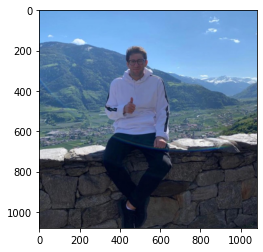

Real tags: ['#tirol', '#merano', '#Italy']
Words


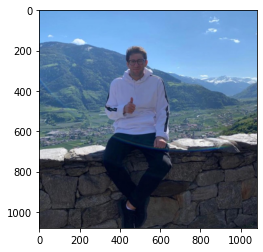

Pred tags: ['#tirol', '#merano', '#Italy']
Images


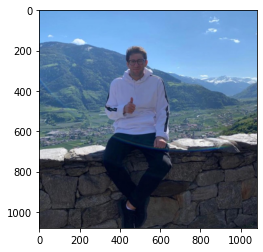

Pred tags: ['#tirol', '#merano', '#Italy']
Words


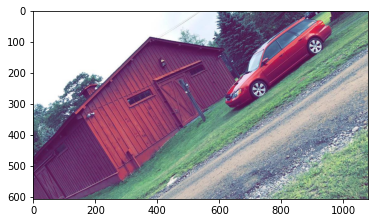

Pred tags: ['#legacygt', '#boosted', '#slow']
Images


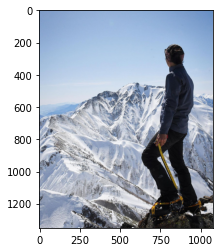

Pred tags: ['#俺ホ', '#自撮りハイカー', '#私の山フォト', '#北アルフ', '#厳冬期', '#八方尾根', '#登山記me', '#唐松岳', '#五竜岳', '#写真て', '#山岳写真', '#山フォトコン', '#山岳モテ', '#写真撮るのか', '#写真撮られるのか', '#mountainphotography', '#hyakkeime', '#naganojapan', '#hakuba', '#hakubavalley']
Words


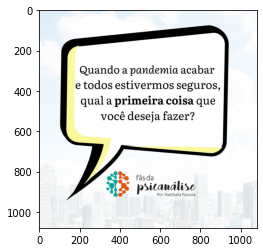

Pred tags: ['#fasdapsicanalise', '#natthaliapaccola', '#psi', '#psicanalise', '#psicologia', '#autoestima', '#façaterapia']
Images


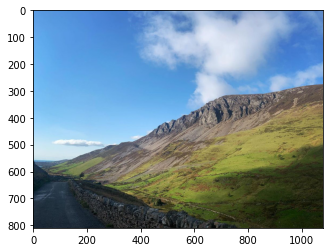

Pred tags: ['#northwales', '#mountains', '#rivers', '#ruins', '#forrests', '#adventures', '#lazymornings', '#myfaves', '#hadthebesttime']
Words


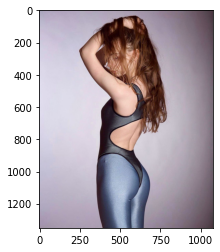

Pred tags: ['#model', '#photography', '#love', '#live', '#brunette', '#longhair', '#greeneyes', '#russiangirl', '#beautiful', '#valerisowa', '#модель', '#фотосессия', '#любовь', '#жизньпрекрасна', '#брюнетка', '#длинныеволосы', '#зеленыеглаза', '#русскаядевушка', '#красота', '#валерисова']
Images


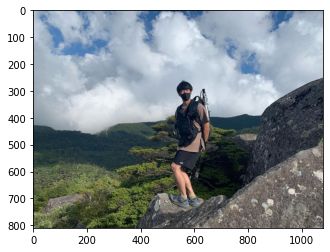

Pred tags: ['#登山', '#山', '#登山女子', '#天狗岳', '#東天狗岳', '#西天狗岳', '#山フォト', '#山ホ', '#登山好き', '#山登り', '#登山好きな人と繋か', '#私の山フォト', '#登山記me', '#山スタク', '#山歩き', '#アウトト', '#アウトト']
Words


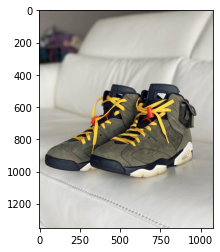

Pred tags: ['#Nike', '#Travis', '#Jordan', '#Sneakers']
Images


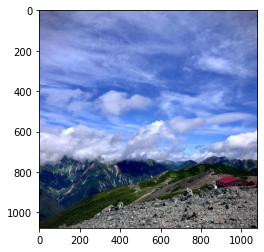

Pred tags: ['#蝶ヶ岳', '#夏山', '#北アルフ', '#山か', '#みんなの登山記', '#山カ', '#登山', '#山登り', '#みんなの登山部', '#自然', '#山', '#写真', '#山ホ', '#私の山フォト', '#yamap55', '#hyakkeime', '#登山記me', '#山好きな人と繋か', '#登山好きな人と繋か', '#絶景', '#日帰り登山', '#山女', '#登山女子', '#mountain', '#yamahack', '#やまホ', '#自然大好き', '#風景写真', '#登山記録', '#トレッキンク']



In [273]:
idx = 2
plt.imshow(imgs[idx])
plt.show()

example_word = imgs_embeddings[idx : idx + 1]
example_pic = imgs_pic_embeddings[idx : idx + 1][0].numpy()

results_word = knn_words.kneighbors(example_word, return_distance = False)
results_pic = knn_pic.kneighbors(example_pic, return_distance = False)

real_tags = imgs_tags[idx]
print(f"Real tags: {real_tags}")

for res_img, res_word in zip(results_pic, results_word):
    for pred_idx_img, pred_idx_word in zip(res_img, res_word):
        print("======================================================================")
        print('Words')
        plt.imshow(imgs[pred_idx_word])
        plt.show()
        print(f"Pred tags: {imgs_tags[pred_idx_word]}")
        print("Images")
        plt.imshow(imgs[pred_idx_img])
        plt.show()
        print(f"Pred tags: {imgs_tags[pred_idx_img]}")
        print("=======================================================================")
    print()

Probable places
park : 16.114133834838867%
campsite : 8.226386070251465%
yard : 6.003779888153076%
ticket_booth : 5.318057060241699%
amusement_park : 3.86490535736084%

Probable objects
['Tree', 'Flag']


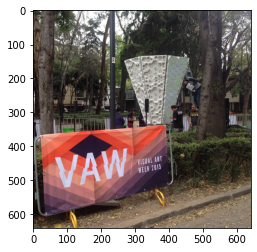

In [32]:

img = Image.open('dataset/912489424275322455.jpg')
places, logits = classifier.predict(np.array(img))
print("Probable places")
for name, prob in places.items():
    print(f"{name} : {prob * 100}%")
print()
print("Probable objects")
objects = detector.get_objects_on_img(img, min_score = 0.2)
print(objects)
plt.imshow(img)

In [38]:
places_preproc = [obj.split('_') for obj in places.keys()]

In [53]:
places_emb = get_embedding(objects)
obj_embeddings = []
for place in places_preproc:
    obj_emb = get_embedding(place)
    obj_embeddings.append(obj_emb)
obj_embeddings = np.array(obj_embeddings)
obj_emb = np.mean(obj_embeddings, axis = 0)